In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/Shareddrives/Healthcare_Fraud/Unzipped_Files

/content/drive/Shareddrives/Healthcare_Fraud/Unzipped_Files


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from keras.callbacks import EarlyStopping
from sklearn.metrics import roc_curve, auc, f1_score, confusion_matrix
from keras.layers import Dense, Dropout, BatchNormalization
from keras.regularizers import l2
import joblib

import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [ ]:
# Helper functions

# predicts the probabability of class label using the model
def pred_prob(clf, data):
    y_pred = clf.predict(data)

    # For binary classification, extract the probability for the positive class
    if y_pred.ndim > 1 and y_pred.shape[1] > 1:
        y_pred = y_pred[:, 1]
    return y_pred

def find_best_threshold(threshold, fpr, tpr):
    t = threshold[np.argmax(tpr*(1-fpr))]
#     print("max(tpr*(1-fpr)) = ", max(tpr*(1-fpr)), "for threshold = ", np.round(t,3))
    return t

# calculate auc for train and test
def draw_roc(train_fpr, train_tpr, test_fpr, test_tpr):
    train_auc = auc(train_fpr, train_tpr)
    test_auc = auc(test_fpr, test_tpr)
    plt.plot(train_fpr, train_tpr, label="Train AUC =" + "{:.4f}".format(train_auc))
    plt.plot(test_fpr, test_tpr, label="Test AUC =" + "{:.4f}".format(test_auc))
    plt.legend()
    plt.xlabel("False Positive Rate (FPR)", size=14)
    plt.ylabel("True Positive Rate (TPR)", size=14)
    plt.title("Area Under Curve", size=16)
    plt.grid(True)
    plt.show()

def predict_with_best_t(proba, threshold):
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

# Confusion matrix for train and test dataset
def draw_confusion_matrix(best_t, x_train, x_test, y_train, y_test, y_train_pred, y_test_pred):

    fig, ax = plt.subplots(1,2, figsize=(20,6))

    train_prediction = predict_with_best_t(y_train_pred, best_t)
    cm = confusion_matrix(y_train, train_prediction)
    sns.heatmap(cm, annot=True, fmt='d', ax=ax[0])
    ax[0].set_title('Train Dataset Confusion Matrix', size = 16)
    ax[0].set_xlabel("Predicted Label", size = 14)
    ax[0].set_ylabel("True Label", size = 14)

    test_prediction = predict_with_best_t(y_test_pred, best_t)
    cm = confusion_matrix(y_test, test_prediction)
    sns.heatmap(cm, annot=True, fmt='d', ax=ax[1], cmap='Blues',
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'])
    ax[1].set_title('Confusion Matrix', size = 16)
    ax[1].set_xlabel("Predicted Label", size = 14)
    ax[1].set_ylabel("True Label", size = 14)
    # plt.grid()
    plt.show()

    # Print classification report
    print("Classification Report:")
    print(classification_report(y_test, test_prediction))

    return train_prediction, test_prediction

def validate_model(clf, x_train, x_test, y_train, y_test):
    # predict the probability of train data
    y_train_pred = pred_prob(clf, x_train)
    # predict the probability of test data
    y_test_pred = pred_prob(clf, x_test)
    # calculate tpr, fpr for diffeent thresholds using roc_curve
    train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
    test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

    # calculate auc for train and test
    train_auc = auc(train_fpr, train_tpr)
    print("Train AUC = ", train_auc)
    test_auc = auc(test_fpr, test_tpr)
    print("Test AUC = ", test_auc)

    draw_roc(train_fpr, train_tpr, test_fpr, test_tpr)

    best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

    train_prediction, test_prediction = draw_confusion_matrix(best_t, x_train, x_test, y_train, y_test, y_train_pred, y_test_pred)

    train_f1_score = f1_score(y_train, train_prediction)
    test_f1_score = f1_score(y_test, test_prediction)

    return test_auc, test_f1_score, best_t

## Import data

In [ ]:
Final_Dataset_Provider_Train = pd.read_csv('Final_Train.csv')
print(Final_Dataset_Provider_Train.shape)
Final_Dataset_Provider_Train.head()

(5410, 238)


,Unnamed: 0,Provider,PotentialFraud,InscClaimAmtReimbursed,DeductibleAmtPaid,Hospitalization_Duration,Claim_Period,ExtraClaimDays,Inpatient_or_Outpatient,RenalDiseaseIndicator,...,PerProviderClmDiagnosisCode_4_count_ClaimID,PerProviderClmDiagnosisCode_5_count_ClaimID,PerProviderClmDiagnosisCode_6_count_ClaimID,PerProviderDiagnosisGroupCode_count_ClaimID,Gender_1,Gender_2,Race_1,Race_2,Race_3,Race_5
0,0,PRV51001,0,104640,5340.0,30.0,61,0.0,5,8,...,297,297,297,405,9,16,21,4,0,0
1,1,PRV51003,1,605670,66286.0,382.0,617,0.0,62,29,...,3046,4452,5556,4972,54,78,107,24,0,1
2,2,PRV51004,0,52170,310.0,0.0,362,0.0,0,23,...,13263,15655,17719,22201,46,103,120,24,5,0
3,3,PRV51005,1,280910,3700.0,0.0,2433,0.0,0,259,...,771875,1002383,1134445,1357225,511,654,893,262,10,0
4,4,PRV51007,0,33710,3264.0,19.0,141,0.0,3,11,...,2622,3378,3612,4764,34,38,58,14,0,0


In [ ]:
Final_Dataset_Provider_Train = Final_Dataset_Provider_Train.drop(columns=['Unnamed: 0'], axis=1)
print(Final_Dataset_Provider_Train.shape)
Final_Dataset_Provider_Train.head()

(5410, 237)


,Provider,PotentialFraud,InscClaimAmtReimbursed,DeductibleAmtPaid,Hospitalization_Duration,Claim_Period,ExtraClaimDays,Inpatient_or_Outpatient,RenalDiseaseIndicator,NoOfMonths_PartACov,...,PerProviderClmDiagnosisCode_4_count_ClaimID,PerProviderClmDiagnosisCode_5_count_ClaimID,PerProviderClmDiagnosisCode_6_count_ClaimID,PerProviderDiagnosisGroupCode_count_ClaimID,Gender_1,Gender_2,Race_1,Race_2,Race_3,Race_5
0,PRV51001,0,104640,5340.0,30.0,61,0.0,5,8,300,...,297,297,297,405,9,16,21,4,0,0
1,PRV51003,1,605670,66286.0,382.0,617,0.0,62,29,1560,...,3046,4452,5556,4972,54,78,107,24,0,1
2,PRV51004,0,52170,310.0,0.0,362,0.0,0,23,1768,...,13263,15655,17719,22201,46,103,120,24,5,0
3,PRV51005,1,280910,3700.0,0.0,2433,0.0,0,259,13872,...,771875,1002383,1134445,1357225,511,654,893,262,10,0
4,PRV51007,0,33710,3264.0,19.0,141,0.0,3,11,852,...,2622,3378,3612,4764,34,38,58,14,0,0


## Split your whole data into train and test(80-20)

In [ ]:
Final_Dataset_Provider_Tr, Final_Dataset_Provider_val = train_test_split(Final_Dataset_Provider_Train, test_size=0.2,
                               random_state=42,stratify=Final_Dataset_Provider_Train['PotentialFraud'])
Final_Dataset_Provider_Tr.shape, Final_Dataset_Provider_val.shape

((4328, 237), (1082, 237))

In [ ]:
# Seperate dependent and independent variables
x_train = Final_Dataset_Provider_Tr.drop(axis=1,columns=['Provider','PotentialFraud'])
y_train = Final_Dataset_Provider_Tr['PotentialFraud']
x_train.shape, y_train.shape

((4328, 235), (4328,))

In [ ]:
# Seperate dependent and independent variables
x_validation_provider_labels = Final_Dataset_Provider_val[['Provider','PotentialFraud']]

x_validation = Final_Dataset_Provider_val.drop(columns=['Provider','PotentialFraud'],axis=1)
y_validation = Final_Dataset_Provider_val['PotentialFraud']

x_validation.shape, y_validation.shape

((1082, 235), (1082,))

In [ ]:
# Standardize the data (train and test)
standard_scaler = StandardScaler()
standard_scaler.fit(x_train)
x_tr = standard_scaler.transform(x_train)
x_val = standard_scaler.transform(x_validation)

# convert pandas.core.series.Series to numpy.ndarray
y_tr = y_train.to_numpy()
y_val = y_validation.to_numpy()

In [ ]:
# Now, in the 80% train set, split the train set into D1 and D2.(50-50)
X_train, X_test, y_train, y_test = train_test_split(x_tr, y_tr, test_size=0.5,random_state=42,stratify=y_tr)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2164, 235), (2164, 235), (2164,), (2164,))

### Model 1
0.4881

In [ ]:
# Build the neural network model
model1 = Sequential()

# Add the input layer
model1.add(Dense(128, activation='relu', input_dim=X_train.shape[1]))
model1.add(Dropout(0.5))  # Dropout layer for regularization

# Add additional hidden layers
model1.add(Dense(64, activation='relu'))
model1.add(Dropout(0.5))

model1.add(Dense(32, activation='relu'))
model1.add(Dropout(0.5))

# Add the output layer with a sigmoid activation function for binary classification
model1.add(Dense(1, activation='sigmoid'))

# Compile the model
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model1.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
68/68 [==============================] - 2s 7ms/step - loss: 0.5423 - accuracy: 0.7708 - val_loss: 0.2767 - val_accuracy: 0.9104
Epoch 2/10
68/68 [==============================] - 0s 4ms/step - loss: 0.3198 - accuracy: 0.8840 - val_loss: 0.2189 - val_accuracy: 0.9224
Epoch 3/10
68/68 [==============================] - 0s 5ms/step - loss: 0.2919 - accuracy: 0.9053 - val_loss: 0.1895 - val_accuracy: 0.9344
Epoch 4/10
68/68 [==============================] - 0s 7ms/step - loss: 0.2740 - accuracy: 0.9076 - val_loss: 0.1942 - val_accuracy: 0.9242
Epoch 5/10
68/68 [==============================] - 1s 10ms/step - loss: 0.2486 - accuracy: 0.9117 - val_loss: 0.1943 - val_accuracy: 0.9131
Epoch 6/10
68/68 [==============================] - 0s 7ms/step - loss: 0.2773 - accuracy: 0.9136 - val_loss: 0.1819 - val_accuracy: 0.9321
Epoch 7/10
68/68 [==============================] - 0s 7ms/step - loss: 0.2520 - accuracy: 0.9187 - val_loss: 0.1799 - val_accuracy: 0.9288
Epoch 8/10
68/68 [=

68/68 [==============================] - 0s 3ms/step
Train AUC =  0.910910538756993
Test AUC =  0.934944641253116


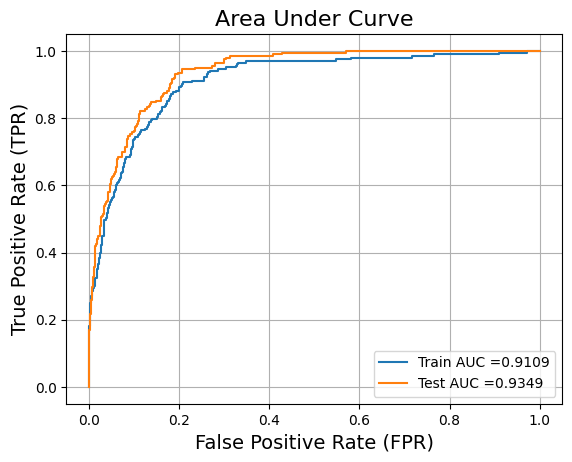

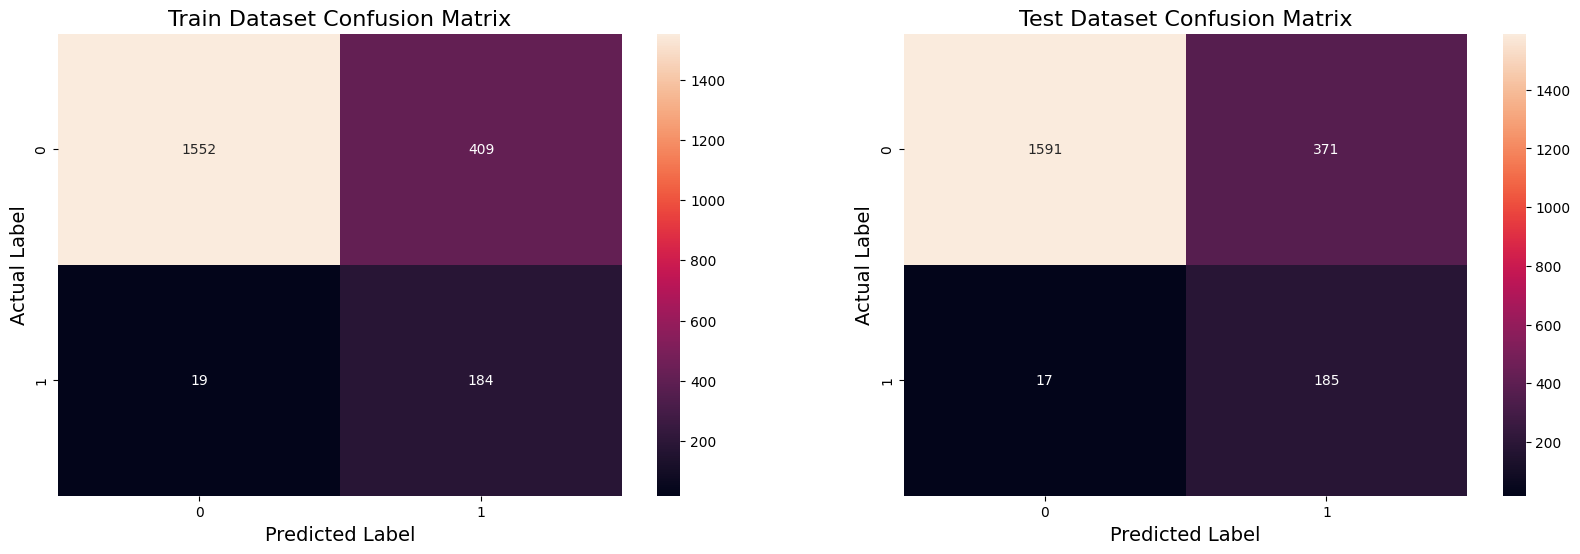

Best Threshold = 0.0437
Model AUC is : 0.9349
Model F1 Score is : 0.4881


In [ ]:
# Evaluate the model on the test set
test_auc, test_f1_score, best_t = validate_model(model1, X_train, X_test, y_train, y_test)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

### Model 2
0.5452

In [ ]:
model2 = Sequential()

# Add the input layer
model2.add(Dense(256, activation='relu', input_dim=X_train.shape[1]))
model2.add(Dropout(0.5))  # Dropout layer for regularization

# Add additional hidden layers with more neurons
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.5))

model2.add(Dense(64, activation='relu'))
model2.add(Dropout(0.5))

# Add the output layer with a sigmoid activation function for binary classification
model2.add(Dense(1, activation='sigmoid'))

# Compile the model with a lower learning rate for potentially smoother convergence
optimizer = Adam(learning_rate=0.001)
model2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with more epochs and potentially a larger batch size
model2.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/20
34/34 [==============================] - 2s 14ms/step - loss: 0.3990 - accuracy: 0.8799 - val_loss: 0.2421 - val_accuracy: 0.8877
Epoch 2/20
34/34 [==============================] - 0s 9ms/step - loss: 0.3333 - accuracy: 0.9025 - val_loss: 0.2092 - val_accuracy: 0.9016
Epoch 3/20
34/34 [==============================] - 0s 8ms/step - loss: 0.2722 - accuracy: 0.9043 - val_loss: 0.1822 - val_accuracy: 0.9279
Epoch 4/20
34/34 [==============================] - 0s 11ms/step - loss: 0.2541 - accuracy: 0.9168 - val_loss: 0.1845 - val_accuracy: 0.9311
Epoch 5/20
34/34 [==============================] - 0s 11ms/step - loss: 0.2904 - accuracy: 0.9048 - val_loss: 0.1742 - val_accuracy: 0.9339
Epoch 6/20
34/34 [==============================] - 0s 8ms/step - loss: 0.2643 - accuracy: 0.9177 - val_loss: 0.2001 - val_accuracy: 0.9043
Epoch 7/20
34/34 [==============================] - 0s 8ms/step - loss: 0.2340 - accuracy: 0.9108 - val_loss: 0.1713 - val_accuracy: 0.9358
Epoch 8/20
34/34 

68/68 [==============================] - 0s 3ms/step
Train AUC =  0.9251789199739752
Test AUC =  0.9401550246767796


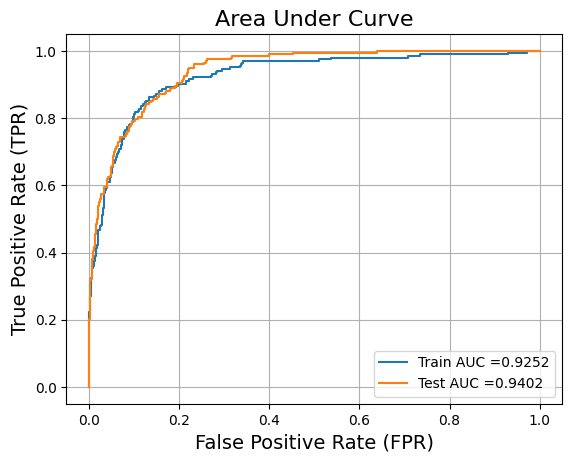

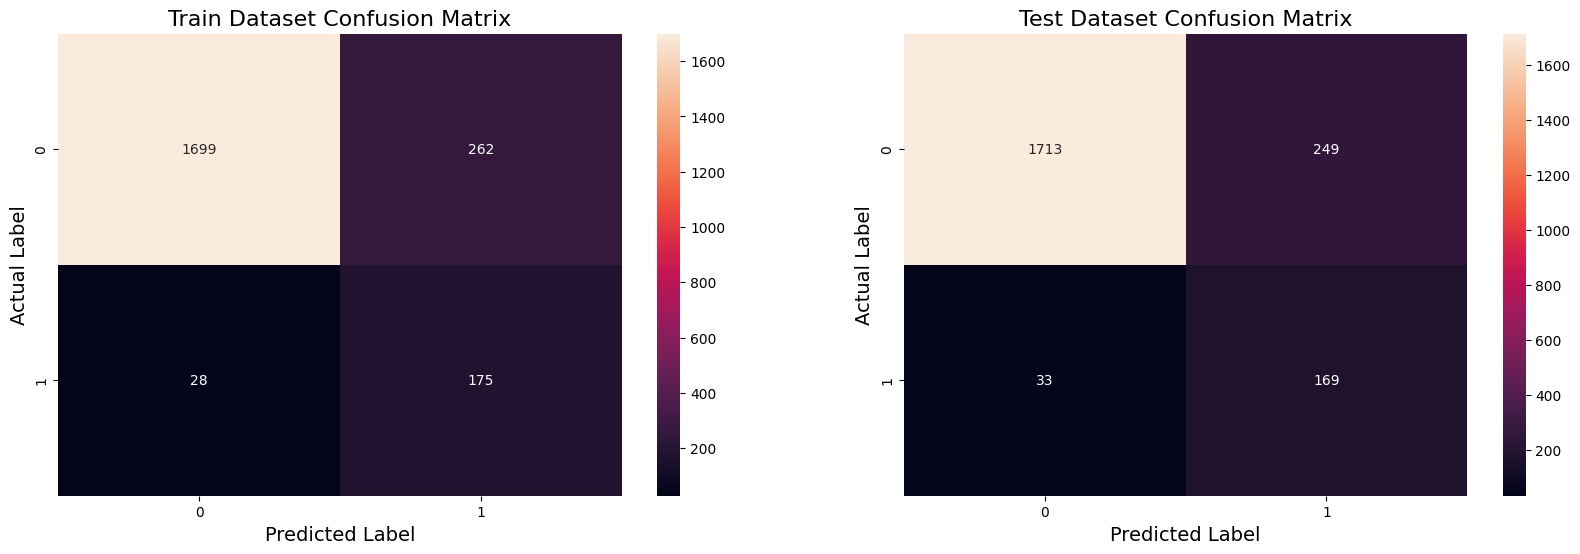

Best Threshold = 0.1566
Model AUC is : 0.9402
Model F1 Score is : 0.5452


In [ ]:
# Evaluate the model on the test set
y_test_pred_raw = model2.predict(X_test)
test_auc, test_f1_score, best_t = validate_model(model2, X_train, X_test, y_train, y_test)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

### Model 3
0.5255

In [ ]:
model3 = Sequential()

# Add the input layer
model3.add(Dense(256, activation='relu', input_dim=X_train.shape[1]))
model3.add(Dropout(0.5))  # Dropout layer for regularization

# Add additional hidden layers with more neurons
model3.add(Dense(128, activation='relu'))
model3.add(Dropout(0.5))

model3.add(Dense(64, activation='relu'))
model3.add(Dropout(0.5))

# Add the output layer with a sigmoid activation function for binary classification
model3.add(Dense(1, activation='sigmoid'))

# Compile the model with a lower learning rate for potentially smoother convergence
optimizer = Adam(learning_rate=0.001)
model3.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Use early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with more epochs and potentially a larger batch size
model3.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping])


Epoch 1/30
34/34 [==============================] - 2s 21ms/step - loss: 0.4165 - accuracy: 0.8577 - val_loss: 0.2466 - val_accuracy: 0.9233
Epoch 2/30
34/34 [==============================] - 1s 16ms/step - loss: 0.3261 - accuracy: 0.8983 - val_loss: 0.2169 - val_accuracy: 0.9247
Epoch 3/30
34/34 [==============================] - 0s 9ms/step - loss: 0.2773 - accuracy: 0.9006 - val_loss: 0.1909 - val_accuracy: 0.9293
Epoch 4/30
34/34 [==============================] - 0s 8ms/step - loss: 0.2656 - accuracy: 0.9159 - val_loss: 0.1847 - val_accuracy: 0.9274
Epoch 5/30
34/34 [==============================] - 0s 8ms/step - loss: 0.2475 - accuracy: 0.9053 - val_loss: 0.1856 - val_accuracy: 0.9298
Epoch 6/30
34/34 [==============================] - 0s 8ms/step - loss: 0.2171 - accuracy: 0.9154 - val_loss: 0.1732 - val_accuracy: 0.9344
Epoch 7/30
34/34 [==============================] - 0s 8ms/step - loss: 0.2348 - accuracy: 0.9191 - val_loss: 0.1787 - val_accuracy: 0.9302
Epoch 8/30
34/34 [

68/68 [==============================] - 0s 2ms/step
Train AUC =  0.9249226920014167
Test AUC =  0.9410608492041865


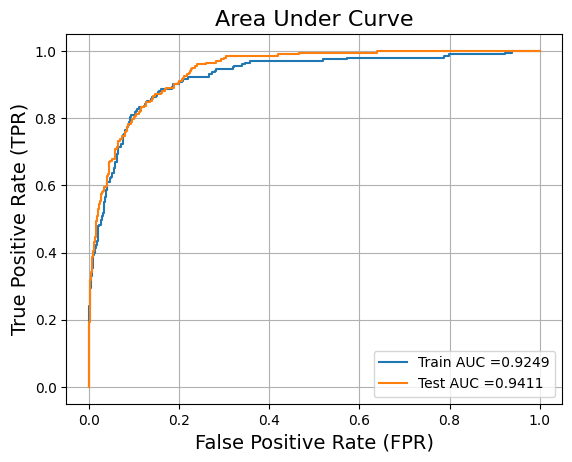

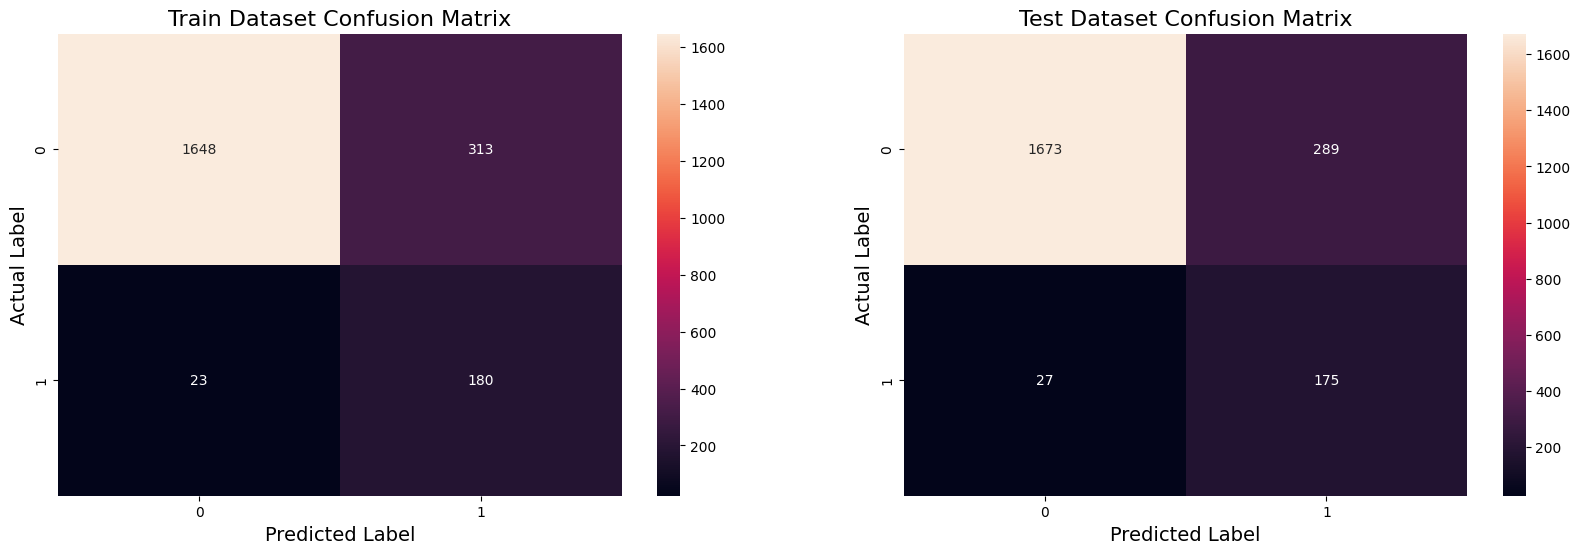

Best Threshold = 0.1140
Model AUC is : 0.9411
Model F1 Score is : 0.5255


In [ ]:
# Evaluate the model on the test set
y_test_pred_raw = model3.predict(X_test)
test_auc, test_f1_score, best_t = validate_model(model3, X_train, X_test, y_train, y_test)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

### Model 4
0.5122

In [ ]:
model4 = Sequential()

# Add the input layer
model4.add(Dense(256, activation='relu', input_dim=X_train.shape[1]))
model4.add(Dropout(0.5))  # Dropout layer for regularization

# Add additional hidden layers with more neurons
model4.add(Dense(128, activation='relu'))
model4.add(Dropout(0.5))

model4.add(Dense(64, activation='relu'))
model4.add(Dropout(0.5))

# Add the output layer with a sigmoid activation function for binary classification
model4.add(Dense(1, activation='sigmoid'))

# Compile the model with a lower learning rate for potentially smoother convergence
optimizer = Adam(learning_rate=0.001)
model4.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Use early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with more epochs and potentially a larger batch size
model4.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/30
34/34 [==============================] - 2s 23ms/step - loss: 0.4481 - accuracy: 0.8928 - val_loss: 0.2525 - val_accuracy: 0.8688
Epoch 2/30
34/34 [==============================] - 1s 15ms/step - loss: 0.3038 - accuracy: 0.8942 - val_loss: 0.2107 - val_accuracy: 0.9214
Epoch 3/30
34/34 [==============================] - 0s 13ms/step - loss: 0.2640 - accuracy: 0.9094 - val_loss: 0.1910 - val_accuracy: 0.9238
Epoch 4/30
34/34 [==============================] - 0s 12ms/step - loss: 0.2552 - accuracy: 0.9039 - val_loss: 0.1776 - val_accuracy: 0.9330
Epoch 5/30
34/34 [==============================] - 0s 13ms/step - loss: 0.2462 - accuracy: 0.9113 - val_loss: 0.1906 - val_accuracy: 0.9233
Epoch 6/30
34/34 [==============================] - 0s 12ms/step - loss: 0.2434 - accuracy: 0.9131 - val_loss: 0.1819 - val_accuracy: 0.9251
Epoch 7/30
34/34 [==============================] - 0s 13ms/step - loss: 0.2237 - accuracy: 0.9191 - val_loss: 0.1850 - val_accuracy: 0.9150


68/68 [==============================] - 0s 2ms/step
Train AUC =  0.9178651185807986
Test AUC =  0.9359337309877777


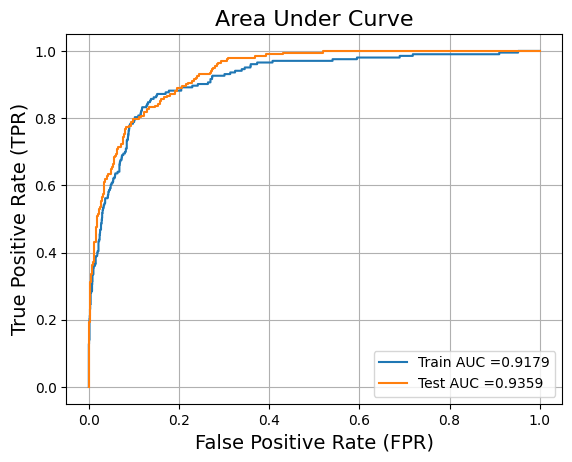

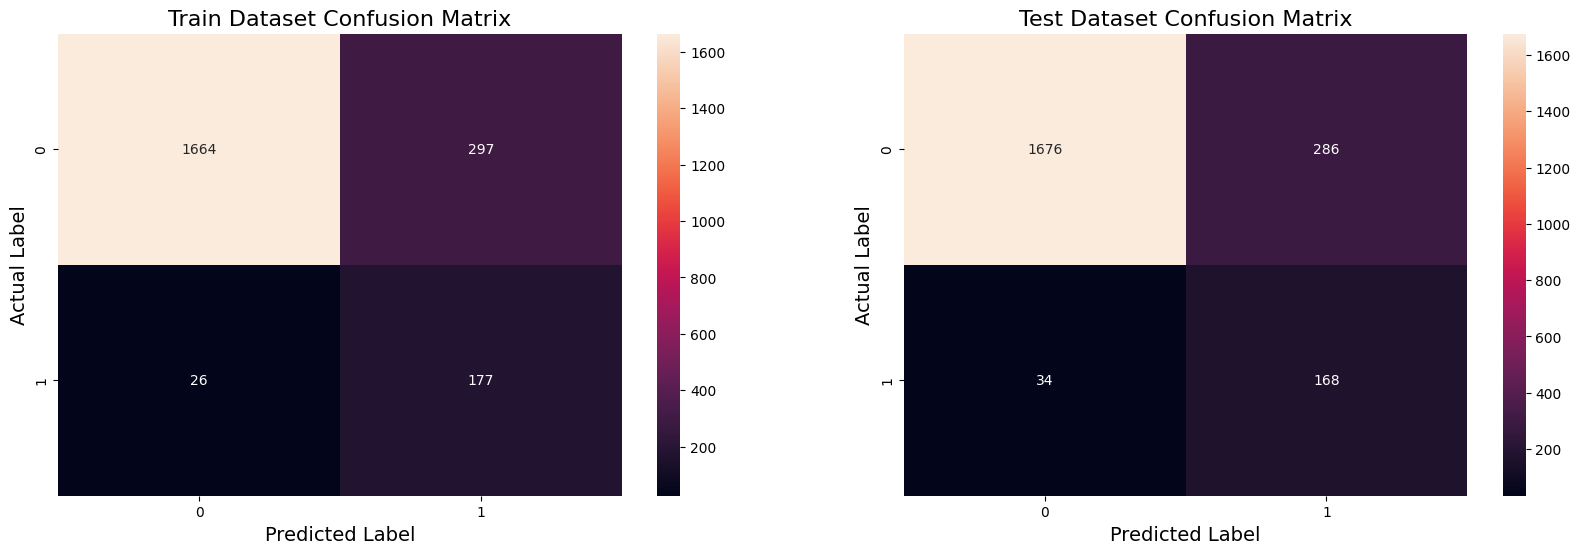

Best Threshold = 0.2455
Model AUC is : 0.9359
Model F1 Score is : 0.5122


In [ ]:
# Evaluate the model on the test set
y_test_pred_raw = model4.predict(X_test)
test_auc, test_f1_score, best_t = validate_model(model4, X_train, X_test, y_train, y_test)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

### Model 5
0.5570

In [ ]:
from keras.optimizers import RMSprop

model5 = Sequential()

# Add the input layer
model5.add(Dense(256, activation='relu', input_dim=X_train.shape[1]))
model5.add(Dropout(0.4))  # Adjust dropout rate

# Add additional hidden layers with more neurons
model5.add(Dense(128, activation='relu'))
model5.add(Dropout(0.4))

model5.add(Dense(64, activation='relu'))
model5.add(Dropout(0.4))

# Add the output layer with a sigmoid activation function for binary classification
model5.add(Dense(1, activation='sigmoid'))

# Compile the model with a different optimizer and learning rate
optimizer = RMSprop(learning_rate=0.0001)
model5.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Use early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with more epochs and potentially a larger batch size
model5.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/50
68/68 [==============================] - 2s 8ms/step - loss: 0.5357 - accuracy: 0.7699 - val_loss: 0.3066 - val_accuracy: 0.9136
Epoch 2/50
68/68 [==============================] - 0s 7ms/step - loss: 0.3210 - accuracy: 0.8872 - val_loss: 0.2509 - val_accuracy: 0.9196
Epoch 3/50
68/68 [==============================] - 0s 7ms/step - loss: 0.2991 - accuracy: 0.8970 - val_loss: 0.2513 - val_accuracy: 0.9187
Epoch 4/50
68/68 [==============================] - 0s 6ms/step - loss: 0.2915 - accuracy: 0.9006 - val_loss: 0.2280 - val_accuracy: 0.9251
Epoch 5/50
68/68 [==============================] - 0s 6ms/step - loss: 0.2618 - accuracy: 0.9043 - val_loss: 0.2248 - val_accuracy: 0.9247
Epoch 6/50
68/68 [==============================] - 0s 6ms/step - loss: 0.2691 - accuracy: 0.9113 - val_loss: 0.2092 - val_accuracy: 0.9270
Epoch 7/50
68/68 [==============================] - 0s 6ms/step - loss: 0.2518 - accuracy: 0.9140 - val_loss: 0.2033 - val_accuracy: 0.9261
Epoch 8/50
68/68 [==

68/68 [==============================] - 0s 2ms/step
Train AUC =  0.9214736625276639
Test AUC =  0.9417244476741252


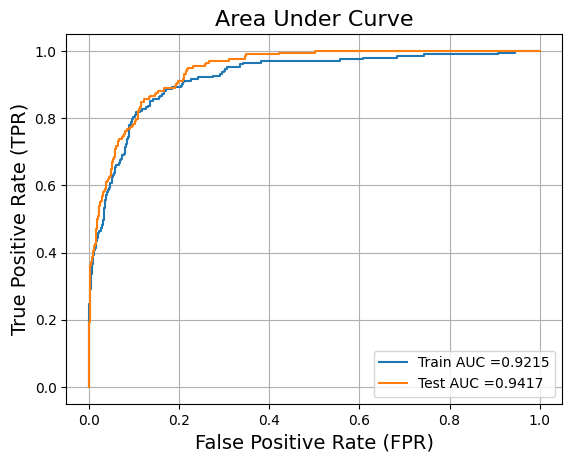

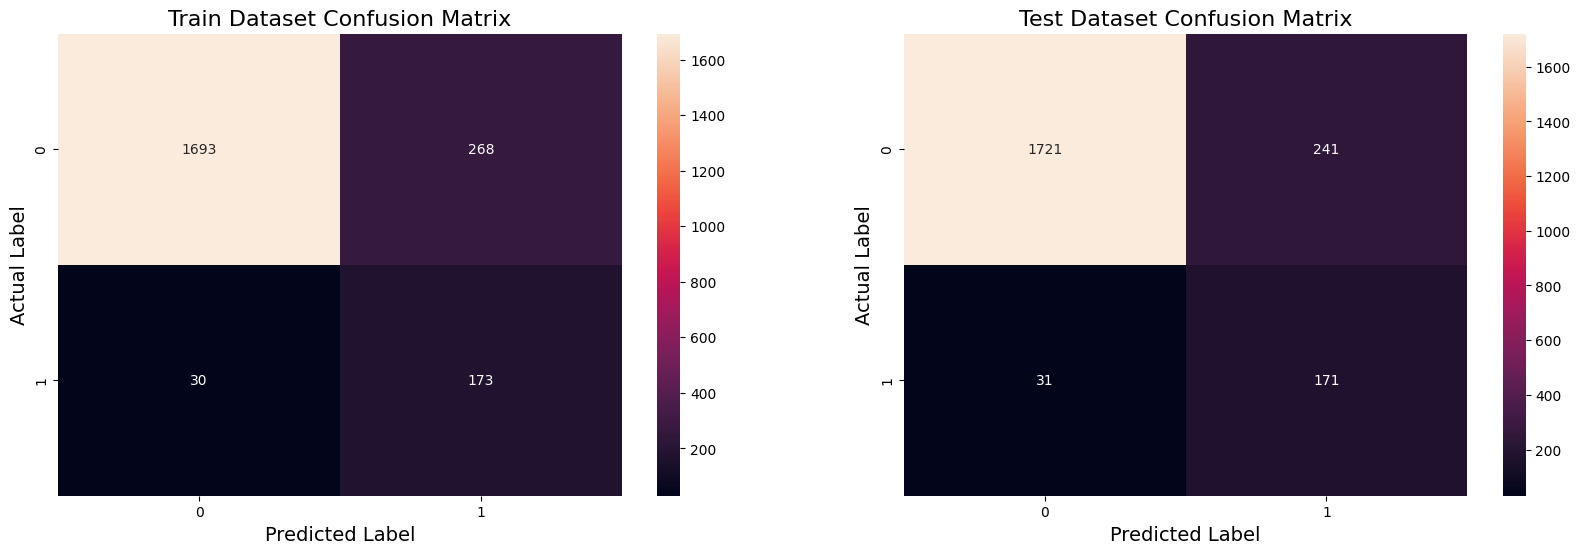

Best Threshold = 0.1381
Model AUC is : 0.9417
Model F1 Score is : 0.5570


In [ ]:
# Evaluate the model on the test set
y_test_pred_raw = model5.predict(X_test)
test_auc, test_f1_score, best_t = validate_model(model5, X_train, X_test, y_train, y_test)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

### Model 6
0.5813

In [ ]:
model6 = Sequential()

# Add the input layer
model6.add(Dense(256, activation='relu', input_dim=X_train.shape[1]))
model6.add(Dropout(0.4))  # Adjust dropout rate

# Add additional hidden layers with more neurons
model6.add(Dense(128, activation='relu'))
model6.add(Dropout(0.4))

model6.add(Dense(64, activation='relu'))
model6.add(Dropout(0.4))

# Add the output layer with a sigmoid activation function for binary classification
model6.add(Dense(1, activation='sigmoid'))

# Compile the model with a different optimizer and learning rate
optimizer = Adam(learning_rate=0.0001)  # Changed optimizer to Adam
model6.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Use early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with more epochs and potentially a larger batch size
model6.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])


Epoch 1/50
68/68 [==============================] - 2s 9ms/step - loss: 0.4817 - accuracy: 0.8443 - val_loss: 0.2843 - val_accuracy: 0.9219
Epoch 2/50
68/68 [==============================] - 0s 6ms/step - loss: 0.3086 - accuracy: 0.8965 - val_loss: 0.2461 - val_accuracy: 0.9117
Epoch 3/50
68/68 [==============================] - 0s 6ms/step - loss: 0.2852 - accuracy: 0.8965 - val_loss: 0.2337 - val_accuracy: 0.9210
Epoch 4/50
68/68 [==============================] - 0s 7ms/step - loss: 0.2700 - accuracy: 0.9034 - val_loss: 0.2258 - val_accuracy: 0.9242
Epoch 5/50
68/68 [==============================] - 0s 6ms/step - loss: 0.2698 - accuracy: 0.8993 - val_loss: 0.2226 - val_accuracy: 0.9191
Epoch 6/50
68/68 [==============================] - 0s 6ms/step - loss: 0.2503 - accuracy: 0.9108 - val_loss: 0.2090 - val_accuracy: 0.9270
Epoch 7/50
68/68 [==============================] - 0s 6ms/step - loss: 0.2338 - accuracy: 0.9104 - val_loss: 0.2022 - val_accuracy: 0.9284
Epoch 8/50
68/68 [==

68/68 [==============================] - 0s 2ms/step
Train AUC =  0.927447291142802
Test AUC =  0.9428094185565346


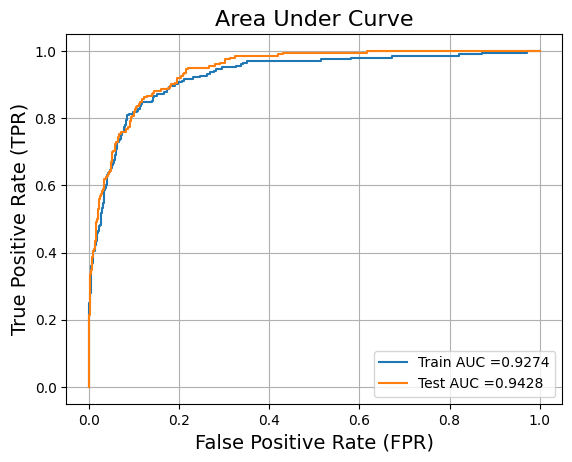

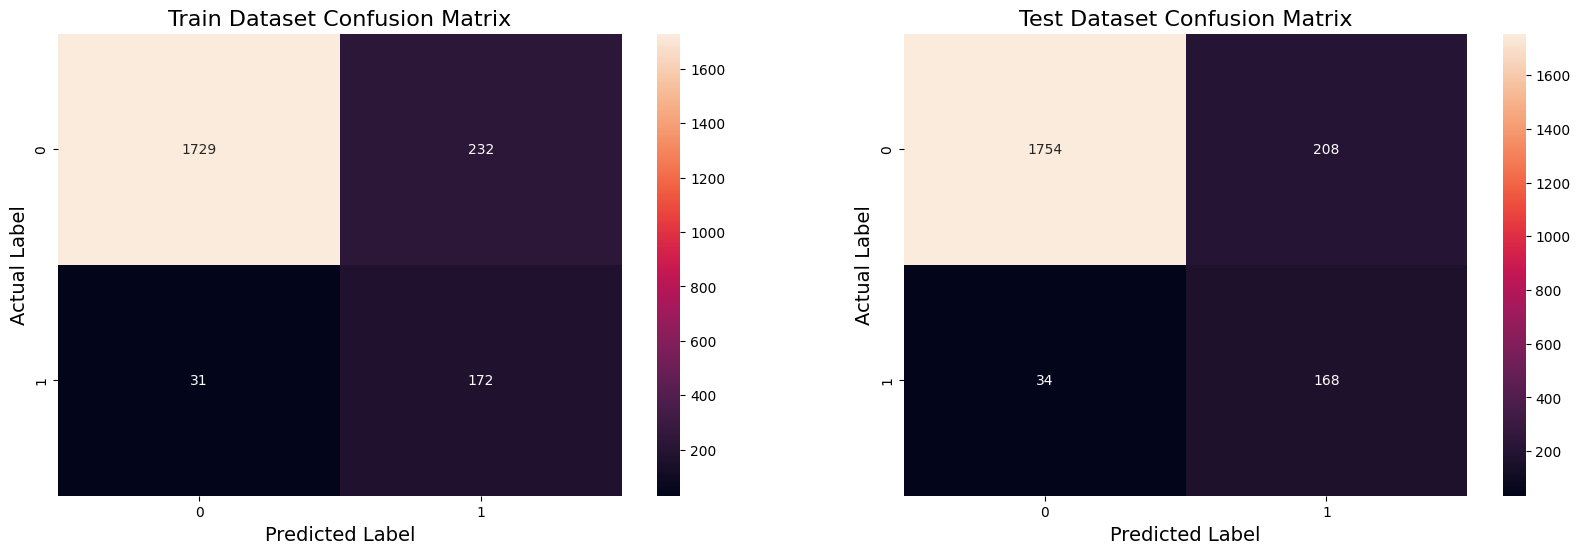

Best Threshold = 0.1684
Model AUC is : 0.9428
Model F1 Score is : 0.5813


In [ ]:
# Evaluate the model on the test set
test_auc, test_f1_score, best_t = validate_model(model6, X_train, X_test, y_train, y_test)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

### Model 7
0.5255

Epoch 1/60
34/34 [==============================] - 2s 19ms/step - loss: 0.6497 - accuracy: 0.7495 - val_loss: 0.4510 - val_accuracy: 0.9191
Epoch 2/60
34/34 [==============================] - 1s 18ms/step - loss: 0.4394 - accuracy: 0.8669 - val_loss: 0.2931 - val_accuracy: 0.9256
Epoch 3/60
34/34 [==============================] - 1s 19ms/step - loss: 0.3983 - accuracy: 0.8891 - val_loss: 0.2528 - val_accuracy: 0.9210
Epoch 4/60
34/34 [==============================] - 1s 26ms/step - loss: 0.3372 - accuracy: 0.8835 - val_loss: 0.2438 - val_accuracy: 0.9205
Epoch 5/60
34/34 [==============================] - 1s 28ms/step - loss: 0.3145 - accuracy: 0.8849 - val_loss: 0.2409 - val_accuracy: 0.9233
Epoch 6/60
34/34 [==============================] - 1s 26ms/step - loss: 0.3153 - accuracy: 0.8979 - val_loss: 0.2383 - val_accuracy: 0.9154
Epoch 7/60
34/34 [==============================] - 1s 27ms/step - loss: 0.3084 - accuracy: 0.8946 - val_loss: 0.2332 - val_accuracy: 0.9251
Epoch 8/60
34

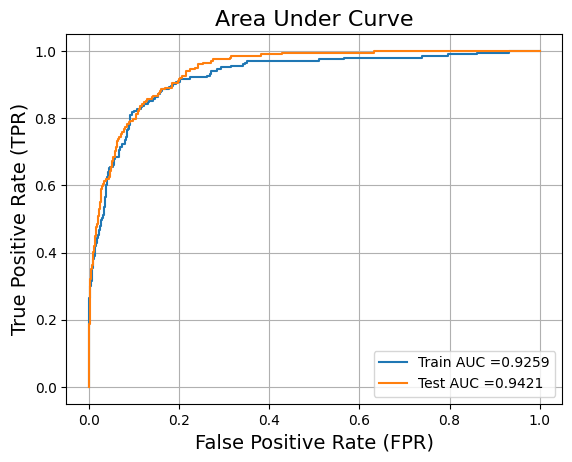

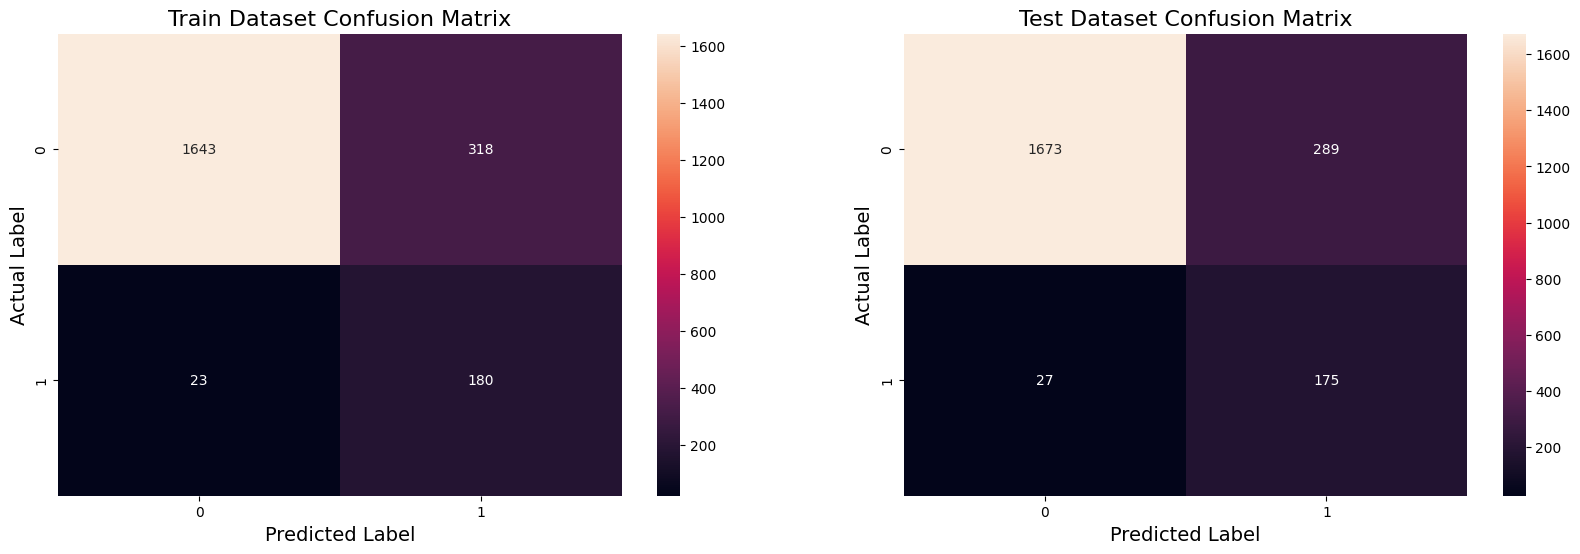

Best Threshold = 0.1127
Model AUC is : 0.9421
Model F1 Score is : 0.5255


In [ ]:
from keras.optimizers import Adam

model7 = Sequential()

# Add the input layer
model7.add(Dense(512, activation='relu', input_dim=X_train.shape[1]))
model7.add(Dropout(0.5))  # Adjust dropout rate

# Add additional hidden layers with more neurons
model7.add(Dense(256, activation='relu'))
model7.add(Dropout(0.5))

model7.add(Dense(128, activation='relu'))
model7.add(Dropout(0.5))

model7.add(Dense(64, activation='relu'))
model7.add(Dropout(0.5))

# Add the output layer with a sigmoid activation function for binary classification
model7.add(Dense(1, activation='sigmoid'))

# Compile the model with a different optimizer and learning rate
optimizer = Adam(learning_rate=0.0001)  # Adjusted learning rate
model7.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Use early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

# Train the model with more epochs and potentially a larger batch size
model7.fit(X_train, y_train, epochs=60, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluate the model on the test set
y_test_pred_raw = model7.predict(X_test)
test_auc, test_f1_score, best_t = validate_model(model7, X_train, X_test, y_train, y_test)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

### Model 8
0.5473

Epoch 1/80
34/34 [==============================] - 3s 23ms/step - loss: 6.9459 - accuracy: 0.4792 - val_loss: 6.6617 - val_accuracy: 0.0924
Epoch 2/80
34/34 [==============================] - 1s 25ms/step - loss: 6.7959 - accuracy: 0.5079 - val_loss: 6.6155 - val_accuracy: 0.0924
Epoch 3/80
34/34 [==============================] - 1s 27ms/step - loss: 6.6608 - accuracy: 0.5522 - val_loss: 6.5365 - val_accuracy: 0.0933
Epoch 4/80
34/34 [==============================] - 1s 27ms/step - loss: 6.5468 - accuracy: 0.5795 - val_loss: 6.4397 - val_accuracy: 0.0966
Epoch 5/80
34/34 [==============================] - 1s 26ms/step - loss: 6.4738 - accuracy: 0.5943 - val_loss: 6.3426 - val_accuracy: 0.3059
Epoch 6/80
34/34 [==============================] - 1s 30ms/step - loss: 6.3852 - accuracy: 0.5873 - val_loss: 6.2586 - val_accuracy: 0.4182
Epoch 7/80
34/34 [==============================] - 1s 31ms/step - loss: 6.2827 - accuracy: 0.6155 - val_loss: 6.1629 - val_accuracy: 0.6890
Epoch 8/80
34

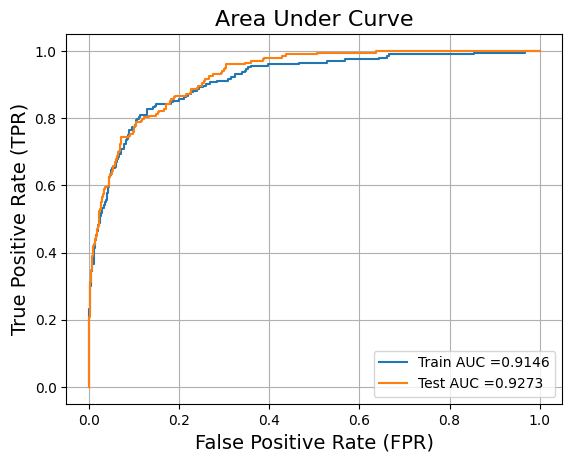

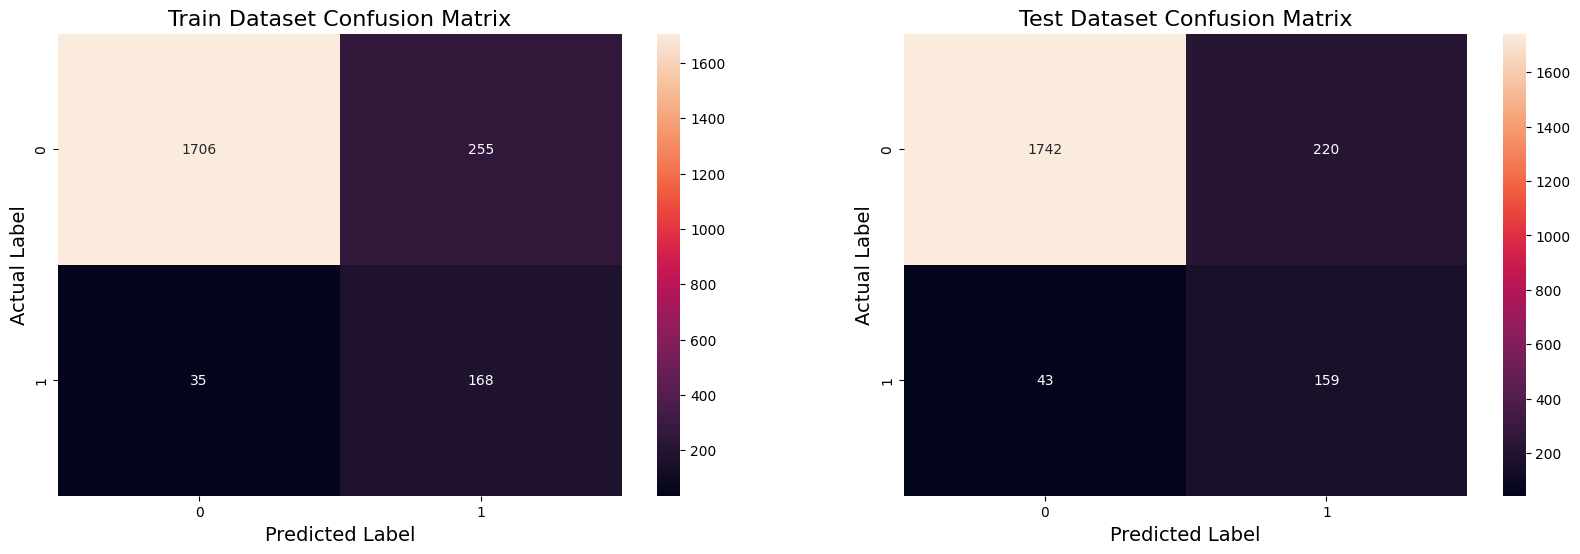

Best Threshold = 0.1854
Model AUC is : 0.9273
Model F1 Score is : 0.5473


In [ ]:
model8 = Sequential()

# Add the input layer
model8.add(Dense(512, activation='relu', input_dim=X_train.shape[1]))
model8.add(BatchNormalization())
model8.add(Dropout(0.5))

# Add additional hidden layers with more neurons
model8.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
model8.add(BatchNormalization())
model8.add(Dropout(0.5))

model8.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model8.add(BatchNormalization())
model8.add(Dropout(0.5))

model8.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model8.add(BatchNormalization())
model8.add(Dropout(0.5))

# Add the output layer with a sigmoid activation function for binary classification
model8.add(Dense(1, activation='sigmoid'))

# Compile the model with a different optimizer and learning rate
optimizer = Adam(learning_rate=0.0001)
model8.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Use early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)

# Train the model with more epochs and potentially a larger batch size
model8.fit(X_train, y_train, epochs=80, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluate the model on the test set
test_auc, test_f1_score, best_t = validate_model(model8, X_train, X_test, y_train, y_test)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

### Model 9
0.5874

Epoch 1/50
68/68 [==============================] - 2s 18ms/step - loss: 0.6227 - accuracy: 0.6950 - val_loss: 0.3790 - val_accuracy: 0.9117
Epoch 2/50
68/68 [==============================] - 1s 8ms/step - loss: 0.3683 - accuracy: 0.8863 - val_loss: 0.2630 - val_accuracy: 0.9177
Epoch 3/50
68/68 [==============================] - 0s 7ms/step - loss: 0.2929 - accuracy: 0.8997 - val_loss: 0.2439 - val_accuracy: 0.9191
Epoch 4/50
68/68 [==============================] - 0s 6ms/step - loss: 0.2872 - accuracy: 0.9002 - val_loss: 0.2308 - val_accuracy: 0.9270
Epoch 5/50
68/68 [==============================] - 0s 6ms/step - loss: 0.2641 - accuracy: 0.8988 - val_loss: 0.2218 - val_accuracy: 0.9265
Epoch 6/50
68/68 [==============================] - 0s 7ms/step - loss: 0.2449 - accuracy: 0.9076 - val_loss: 0.2117 - val_accuracy: 0.9302
Epoch 7/50
68/68 [==============================] - 0s 7ms/step - loss: 0.2574 - accuracy: 0.9090 - val_loss: 0.2061 - val_accuracy: 0.9302
Epoch 8/50
68/68 [=

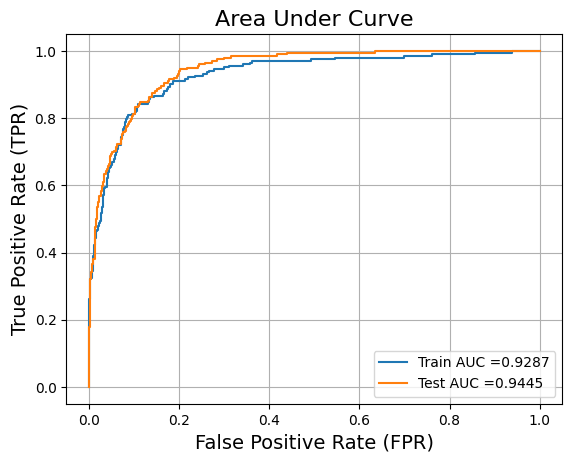

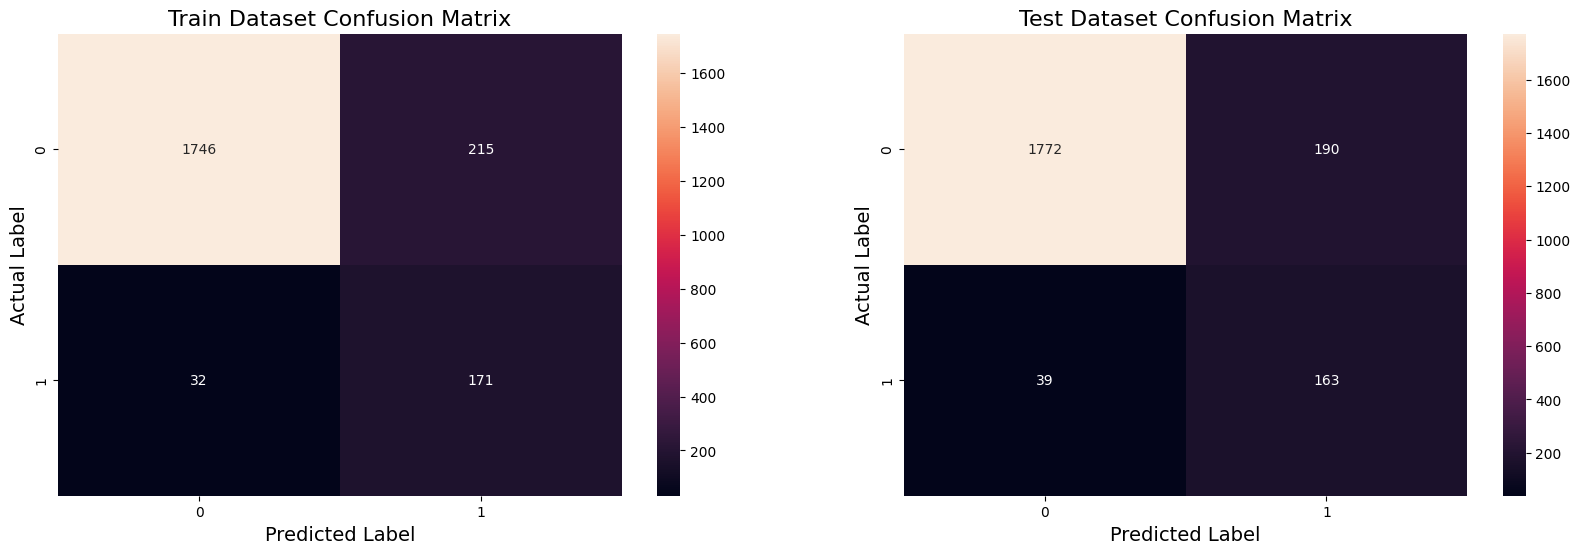

Best Threshold = 0.1776
Model AUC is : 0.9445
Model F1 Score is : 0.5874


In [ ]:
from keras.optimizers import schedules

model9 = Sequential()

# Add the input layer
model9.add(Dense(256, activation='relu', input_dim=X_train.shape[1]))
model9.add(Dropout(0.4))  # Adjust dropout rate

# Add additional hidden layers with more neurons
model9.add(Dense(128, activation='relu'))
model9.add(Dropout(0.4))

model9.add(Dense(64, activation='relu'))
model9.add(Dropout(0.4))

# Add the output layer with a sigmoid activation function for binary classification
model9.add(Dense(1, activation='sigmoid'))

# Compile the model with a different optimizer and learning rate
lr_schedule = schedules.ExponentialDecay(initial_learning_rate=0.0001, decay_steps=10000, decay_rate=0.9)
optimizer = Adam(learning_rate=lr_schedule)  # Changed optimizer to Adam
model9.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Use early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with more epochs and potentially a larger batch size
model9.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluate the model on the test set
test_auc, test_f1_score, best_t = validate_model(model9, X_train, X_test, y_train, y_test)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

### Model 10
 0.5944

Epoch 1/50
68/68 [==============================] - 4s 11ms/step - loss: 0.6733 - accuracy: 0.6738 - val_loss: 0.6888 - val_accuracy: 0.6705
Epoch 2/50
68/68 [==============================] - 0s 7ms/step - loss: 0.5800 - accuracy: 0.7990 - val_loss: 0.6765 - val_accuracy: 0.6645
Epoch 3/50
68/68 [==============================] - 1s 10ms/step - loss: 0.5537 - accuracy: 0.8438 - val_loss: 0.6491 - val_accuracy: 0.6654
Epoch 4/50
68/68 [==============================] - 1s 12ms/step - loss: 0.5289 - accuracy: 0.8651 - val_loss: 0.5912 - val_accuracy: 0.7505
Epoch 5/50
68/68 [==============================] - 1s 12ms/step - loss: 0.4933 - accuracy: 0.8641 - val_loss: 0.5290 - val_accuracy: 0.8346
Epoch 6/50
68/68 [==============================] - 1s 13ms/step - loss: 0.4707 - accuracy: 0.8886 - val_loss: 0.5128 - val_accuracy: 0.8965
Epoch 7/50
68/68 [==============================] - 1s 14ms/step - loss: 0.4483 - accuracy: 0.8923 - val_loss: 0.4972 - val_accuracy: 0.8909
Epoch 8/50
68/

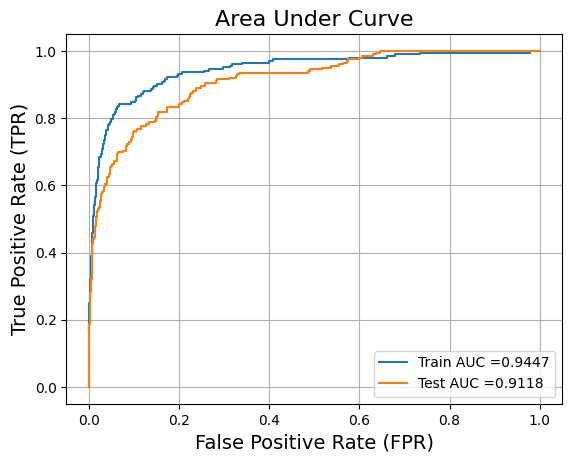

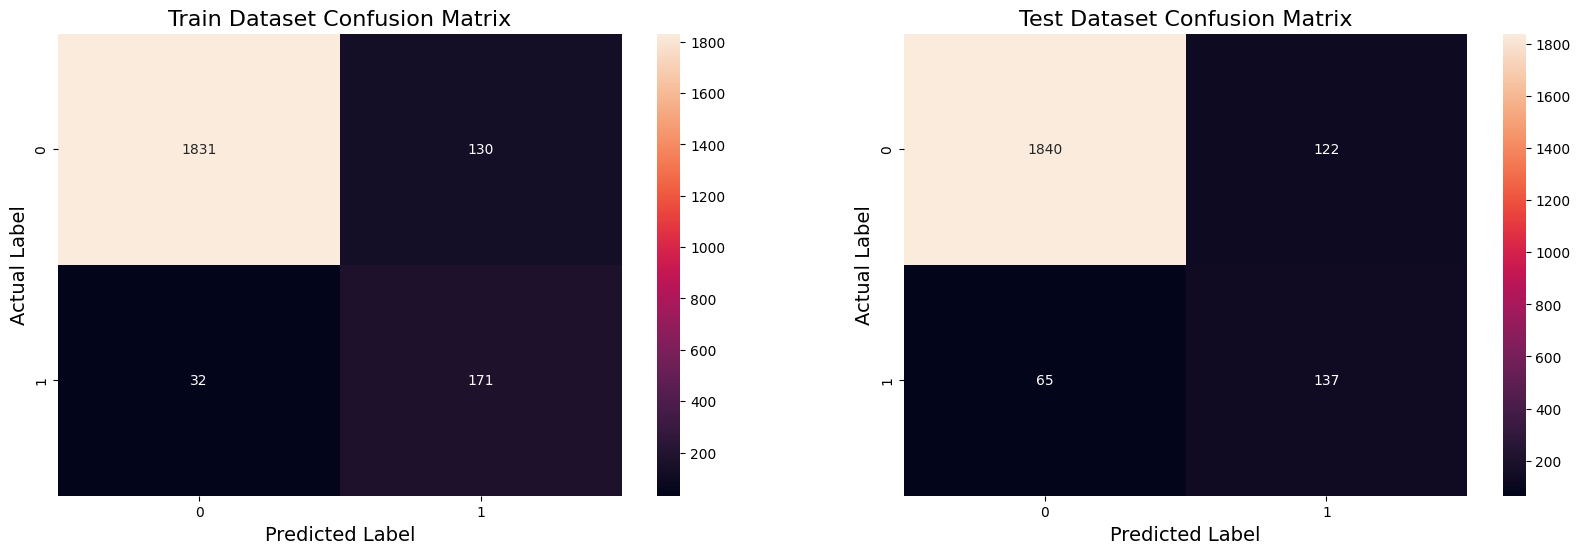

Best Threshold = 0.2436
Model AUC is : 0.9118
Model F1 Score is : 0.5944


In [ ]:
model10 = Sequential()

# Add the input layer
model10.add(Dense(256, activation='relu', input_dim=X_train.shape[1]))
model10.add(BatchNormalization())

# Add additional hidden layers with more neurons
model10.add(Dense(128, activation='relu'))
model10.add(BatchNormalization())

model10.add(Dense(64, activation='relu'))
model10.add(BatchNormalization())

# Add the output layer with a sigmoid activation function for binary classification
model10.add(Dense(1, activation='sigmoid'))

# Compile the model with a different optimizer and learning rate
lr_schedule = schedules.ExponentialDecay(initial_learning_rate=0.0001, decay_steps=10000, decay_rate=0.9)
optimizer = Adam(learning_rate=lr_schedule)
model10.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Use early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with more epochs and potentially a larger batch size
model10.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluate the model on the test set
test_auc, test_f1_score, best_t = validate_model(model10, X_train, X_test, y_train, y_test)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

### Model 11
0.6329

Epoch 1/50
68/68 [==============================] - 4s 22ms/step - loss: 0.6779 - accuracy: 0.7158 - val_loss: 0.6988 - val_accuracy: 0.6340
Epoch 2/50
68/68 [==============================] - 1s 16ms/step - loss: 0.6105 - accuracy: 0.7921 - val_loss: 0.7182 - val_accuracy: 0.4002
Epoch 3/50
68/68 [==============================] - 1s 16ms/step - loss: 0.5669 - accuracy: 0.8447 - val_loss: 0.7051 - val_accuracy: 0.4436
Epoch 4/50
68/68 [==============================] - 1s 14ms/step - loss: 0.5359 - accuracy: 0.8544 - val_loss: 0.6948 - val_accuracy: 0.4427
Epoch 5/50
68/68 [==============================] - 1s 10ms/step - loss: 0.5125 - accuracy: 0.8641 - val_loss: 0.7114 - val_accuracy: 0.4177
Epoch 6/50
68/68 [==============================] - 1s 10ms/step - loss: 0.4936 - accuracy: 0.8748 - val_loss: 0.6071 - val_accuracy: 0.7879
Epoch 7/50
68/68 [==============================] - 1s 10ms/step - loss: 0.4826 - accuracy: 0.8799 - val_loss: 0.4601 - val_accuracy: 0.9117
Epoch 8/50
68

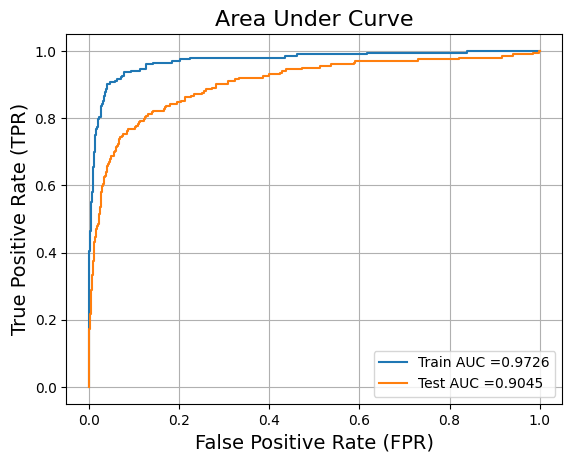

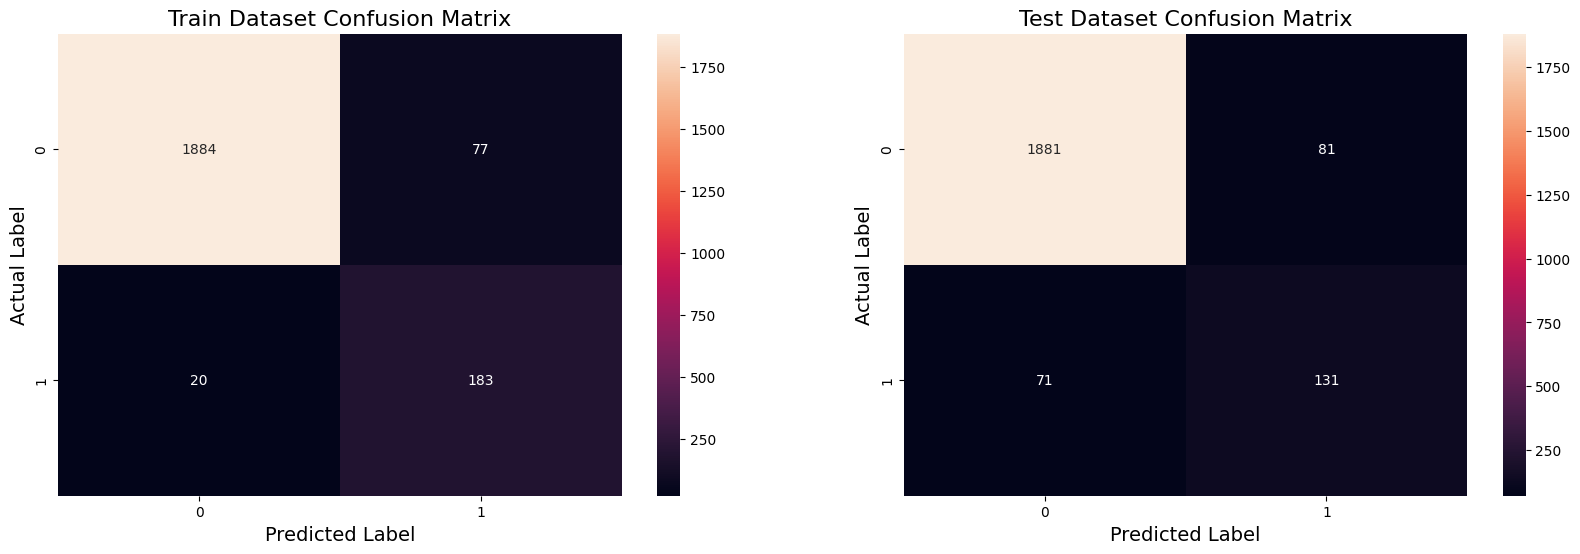

Best Threshold = 0.2541
Model AUC is : 0.9045
Model F1 Score is : 0.6329


In [ ]:
model11 = Sequential()

# Add the input layer
model11.add(Dense(512, activation='relu', input_dim=X_train.shape[1]))
model11.add(BatchNormalization())

# # Add additional hidden layers with more neurons
model11.add(Dense(128, activation='relu'))
model11.add(BatchNormalization())

model11.add(Dense(32, activation='relu'))
model11.add(BatchNormalization())

# Add the output layer with a sigmoid activation function for binary classification
model11.add(Dense(1, activation='sigmoid'))

# Compile the model with a different optimizer and learning rate
lr_schedule = schedules.ExponentialDecay(initial_learning_rate=0.0001,
                                         decay_steps=10000,
                                         decay_rate=0.9)
optimizer = Adam(learning_rate=lr_schedule)
model11.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Use early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with more epochs and potentially a larger batch size
model11.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluate the model on the test set
test_auc, test_f1_score, best_t = validate_model(model11, X_train, X_test, y_train, y_test)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

In [ ]:
#model11.save('ss_model_0.6329.h5')

### Model 12

In [ ]:
import numpy as np
np.random.seed(42)  # Setting a seed for reproducibility

Epoch 1/60
68/68 [==============================] - 4s 14ms/step - loss: 0.6487 - accuracy: 0.7398 - val_loss: 0.6527 - val_accuracy: 0.7163
Epoch 2/60
68/68 [==============================] - 1s 10ms/step - loss: 0.5912 - accuracy: 0.8304 - val_loss: 0.6502 - val_accuracy: 0.6571
Epoch 3/60
68/68 [==============================] - 1s 10ms/step - loss: 0.5635 - accuracy: 0.8433 - val_loss: 0.6429 - val_accuracy: 0.6853
Epoch 4/60
68/68 [==============================] - 1s 12ms/step - loss: 0.5351 - accuracy: 0.8789 - val_loss: 0.5883 - val_accuracy: 0.8226
Epoch 5/60
68/68 [==============================] - 1s 13ms/step - loss: 0.5298 - accuracy: 0.8706 - val_loss: 0.5130 - val_accuracy: 0.8350
Epoch 6/60
68/68 [==============================] - 1s 10ms/step - loss: 0.5069 - accuracy: 0.8757 - val_loss: 0.4581 - val_accuracy: 0.9020
Epoch 7/60
68/68 [==============================] - 1s 9ms/step - loss: 0.4861 - accuracy: 0.8965 - val_loss: 0.4674 - val_accuracy: 0.9108
Epoch 8/60
68/

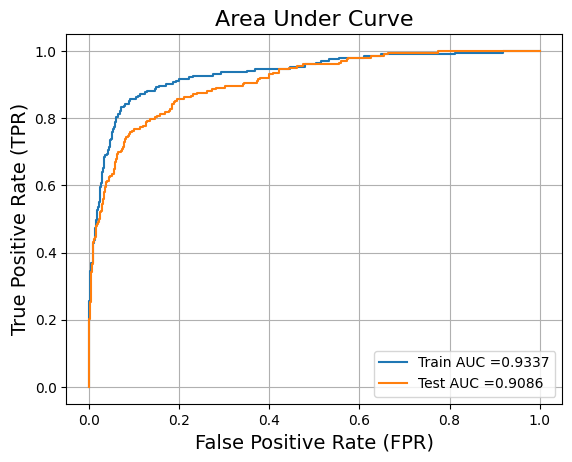

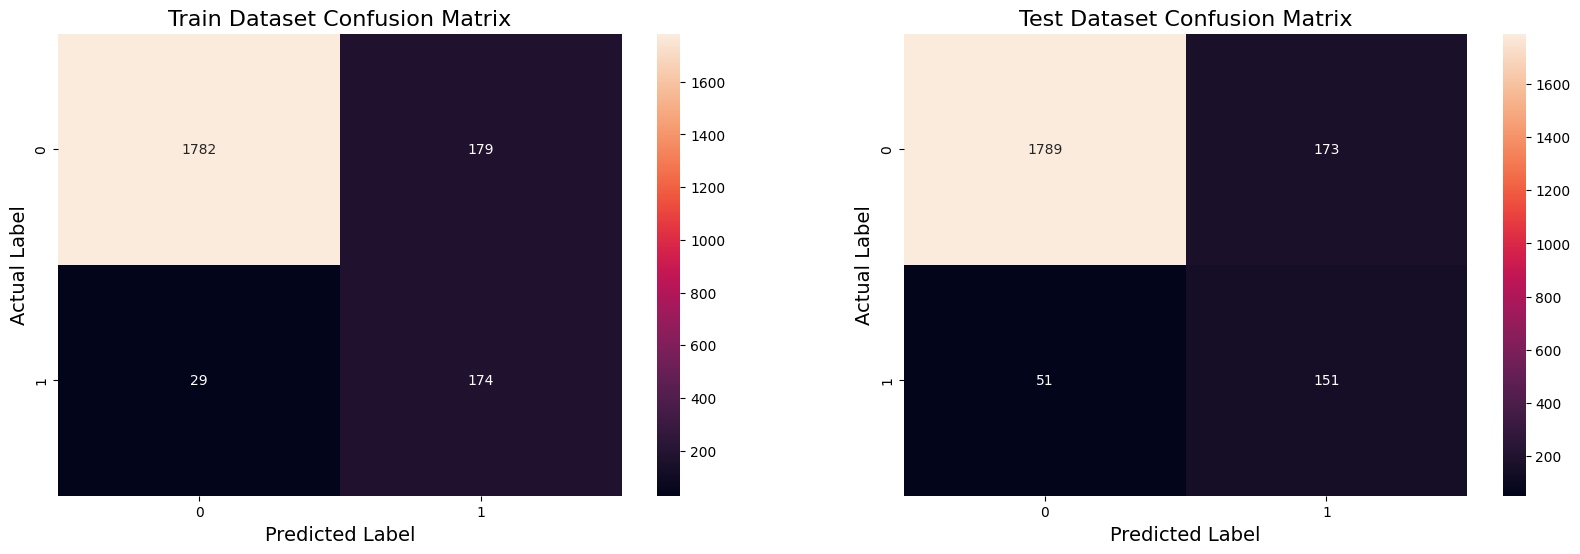

Best Threshold = 0.4548
Model AUC is : 0.9086
Model F1 Score is : 0.5741


In [ ]:
model12 = Sequential()

# Add the input layer
model12.add(Dense(512, activation='relu', input_dim=X_train.shape[1]))
model12.add(BatchNormalization())

# # Add additional hidden layers with more neurons
model12.add(Dense(128, activation='relu'))
model12.add(BatchNormalization())

model12.add(Dense(32, activation='relu'))
model12.add(BatchNormalization())

# Add the output layer with a sigmoid activation function for binary classification
model12.add(Dense(1, activation='sigmoid'))

# Compile the model with a different optimizer and learning rate
lr_schedule = schedules.ExponentialDecay(initial_learning_rate=0.0001, decay_steps=10000, decay_rate=0.9)
optimizer = Adam(learning_rate=lr_schedule)
model12.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Use early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with more epochs and potentially a larger batch size
model12.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluate the model on the test set
test_auc, test_f1_score, best_t = validate_model(model12, X_train, X_test, y_train, y_test)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

### FInal Model

In [ ]:
from tensorflow.keras.models import load_model
model =load_model('ss_model_0.6329.h5')

In [ ]:
model.summary()

Model: "sequential_80"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_309 (Dense)           (None, 512)               120832    
                                                                 
 batch_normalization_152 (B  (None, 512)               2048      
 atchNormalization)                                              
                                                                 
 dense_310 (Dense)           (None, 128)               65664     
                                                                 
 batch_normalization_153 (B  (None, 128)               512       
 atchNormalization)                                              
                                                                 
 dense_311 (Dense)           (None, 32)                4128      
                                                                 
 batch_normalization_154 (B  (None, 32)              

In [ ]:
# rename the layers

# # Get the layer you want to rename
# layer_to_rename = model.get_layer(name='dense_312')

# # Rename the layer
# layer_to_rename._name = 'dense_4'

# rename the model
model._name = 'custom_nn_model_2'

model.summary()

Model: "custom_nn_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 512)               120832    
                                                                 
 batch_normalization_1 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 128)               65664     
                                                                 
 batch_normalization_2 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dense_3 (Dense)             (None, 32)                4128      
                                                                 
 batch_normalization_3 (Bat  (None, 32)          

68/68 [==============================] - 0s 3ms/step
Train AUC =  0.9726338477151749
Test AUC =  0.904494807278893


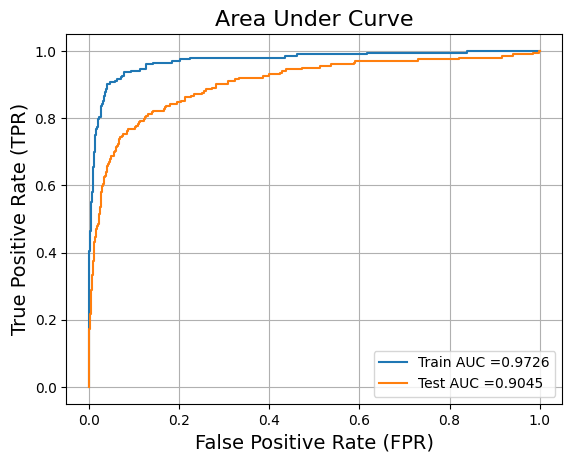

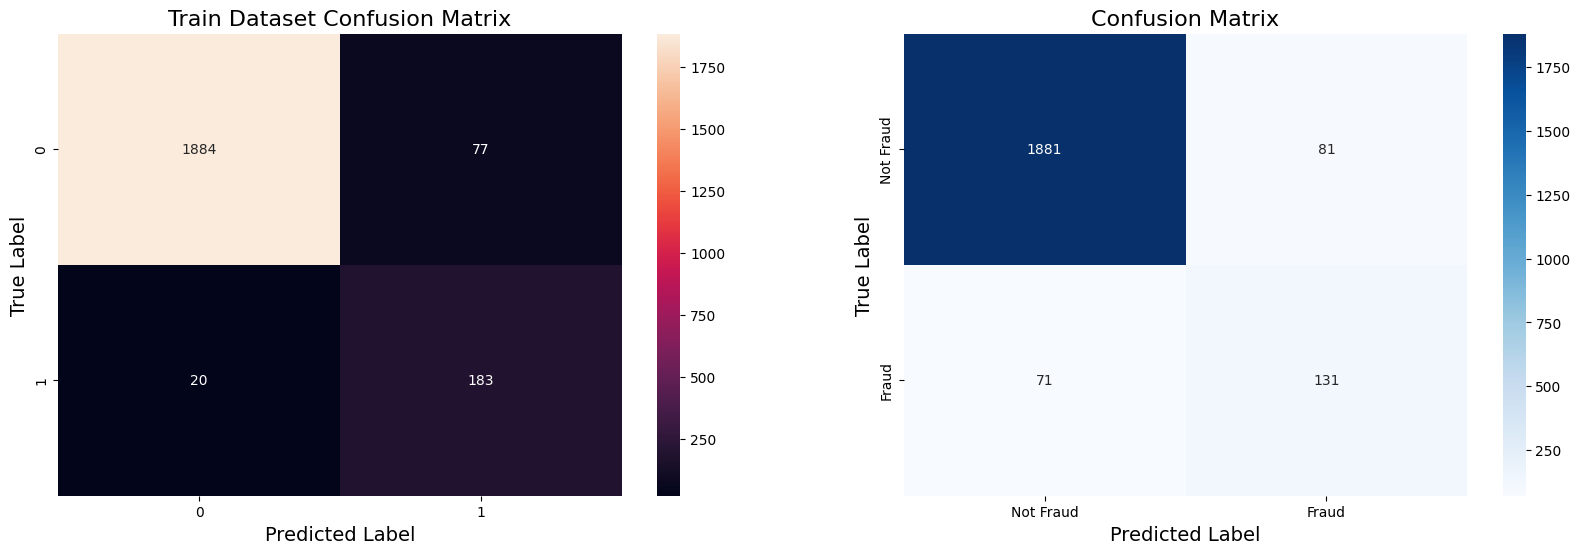

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1962
           1       0.62      0.65      0.63       202

    accuracy                           0.93      2164
   macro avg       0.79      0.80      0.80      2164
weighted avg       0.93      0.93      0.93      2164



In [ ]:
# Evaluate the model on the test set
test_auc, test_f1_score, best_t = validate_model(model, X_train, X_test, y_train, y_test)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Make predictions on the validation set
y_pred = model.predict(x_val_std)
y_pred_binary = np.round(y_pred)  # Convert probabilities to binary predictions (0 or 1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred_binary)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_val, y_pred_binary))

NameError: ignored

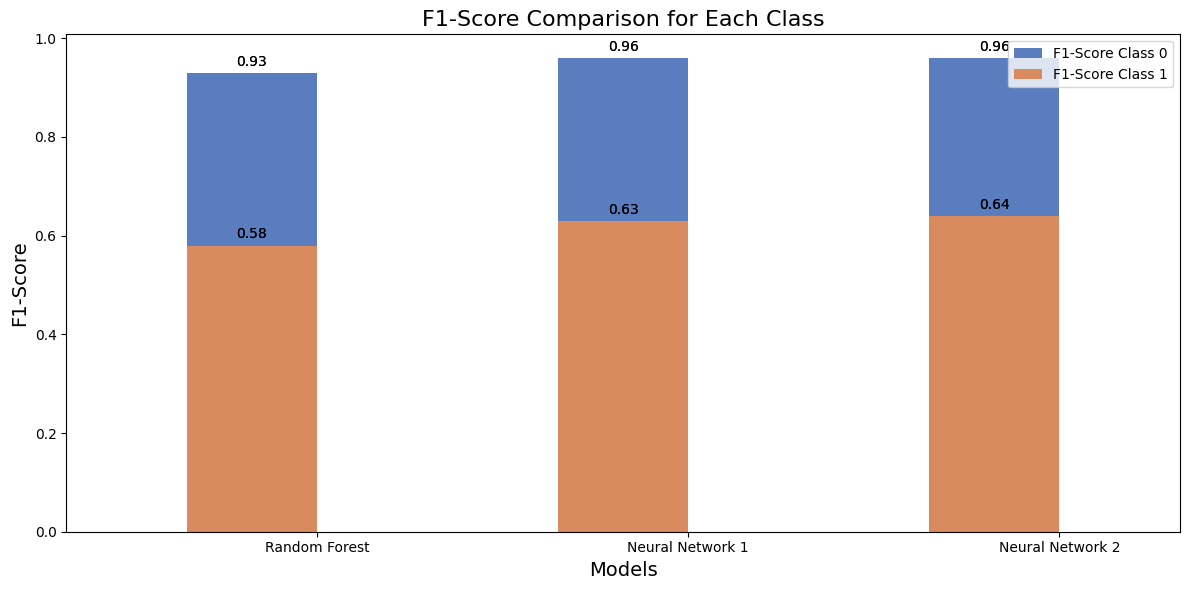

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Model names
models = ['Random Forest', 'Neural Network 1', 'Neural Network 2']

# F1-Score for each class and model
f1_score_class_0 = [0.93, 0.96, 0.96]
f1_score_class_1 = [0.58, 0.63, 0.64]

# Create a muted color palette
palette = sns.color_palette('muted')

# Bar width and positions
bar_width = 0.35
index = np.arange(len(models))

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

# Plotting F1-Score for Class 0
bar1 = sns.barplot(x=index, y=f1_score_class_0, color=palette[0], label='F1-Score Class 0', width=bar_width)

# Plotting F1-Score for Class 1
bar2 = sns.barplot(x=index + bar_width, y=f1_score_class_1, color=palette[1], label='F1-Score Class 1', width=bar_width)

# Adding labels
ax.set_xlabel('Models', fontsize=14)
ax.set_ylabel('F1-Score', fontsize=14)
ax.set_title('F1-Score Comparison for Each Class', fontsize=16)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(models)
ax.legend()

# Display the values on top of the bars for both classes
for bars in [bar1, bar2]:
    for rect in bars.patches:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), textcoords='offset points',
                    ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()
